In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import imageio
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader, Dataset

(32, 32, 3)


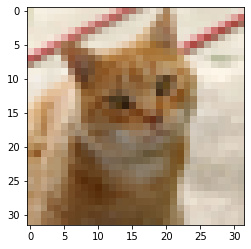

In [32]:
img_name = 'cat.jpg'
n_PE = 10
dimx, dimy = 32, 32
epochs = 5000
lr = 1e-5
gif_name = img_name.split('.')[0] + '_' + str(dimx) + 'x' + str(dimy) + '_' + 'PE' + str(n_PE) + '_' + 'epoch' + str(epochs) + '.gif'

img = Image.open(os.path.join('Data', img_name))
img = np.array(img.resize((dimx, dimy)))
print(img.shape)
plt.imshow(img)
plt.show()

In [33]:
class MyDataset(Dataset):
    def __init__(self, df):
        x=df.iloc[:,0:-3].values
        y=df.iloc[:,-3:].values
        self.x_train=torch.tensor(x, dtype=torch.float32)
        self.y_train=torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx], self.y_train[idx]

class PE_model(nn.Module):
    def __init__(self, inp_size, out_size):
        super().__init__()
        self.hidden1 = nn.Linear(inp_size, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.hidden3 = nn.Linear(256, 256)
        self.hidden4 = nn.Linear(256, 256)
        self.hidden5 = nn.Linear(256, 256)
        # self.act = nn.ReLU()
        self.act = nn.LeakyReLU()
        self.outact = nn.Sigmoid()
        self.output = nn.Linear(256, out_size)

    def forward(self, x):
        x = self.act(self.hidden1(x))
        x = self.act(self.hidden2(x))
        x = self.act(self.hidden3(x))
        x = self.act(self.hidden4(x))
        x = self.act(self.hidden5(x))
        x = self.outact(self.output(x))
        # x = self.output(x)
        return x
        
def Generate_GIF(img, n_PE=5, epochs=1000, lr=1e-5):
    rs, cs, rys, gys, bys = [], [], [], [], []
    frames = []

    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            rs.append(r)
            cs.append(c)
            rys.append(img[r,c,0]/255)
            gys.append(img[r,c,1]/255)
            bys.append(img[r,c,2]/255)
    df = pd.DataFrame({'rs':rs, 'cs':cs, 'ry':rys, 'gy':gys, 'by':bys})

    X = df.iloc[:, :-3].copy()
    Y = df.iloc[:, -3:].copy()
    for i in range(n_PE):
        X[f'sin_2^{i+1}_rs'] = (X['rs']*(2**i)*np.pi/180).map(np.sin)
        X[f'cos_2^{i+1}_rs'] = (X['rs']*(2**i)*np.pi/180).map(np.cos)
        X[f'sin_2^{i+1}_cs'] = (X['cs']*(2**i)*np.pi/180).map(np.sin)
        X[f'cos_2^{i+1}_cs'] = (X['cs']*(2**i)*np.pi/180).map(np.cos)
    df_PE = pd.concat([X, Y], axis=1)

    DS = MyDataset(df)
    DS_loader=DataLoader(DS,batch_size = len(DS), shuffle=False)

    DS_PE=MyDataset(df_PE)
    DS_PE_loader=DataLoader(DS_PE,batch_size = len(DS_PE), shuffle=False)

    model = PE_model(df.shape[1]-3, 3)
    model_PE = PE_model(df_PE.shape[1]-3, 3)

    loss_fn = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer_PE = optim.Adam(model_PE.parameters(), lr=lr)

    for epoch in range(epochs):
        for X_batch, y_batch in DS_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        for X_batch, y_batch in DS_PE_loader:
            y_pred = model_PE(X_batch)
            loss_PE = loss_fn(y_pred, y_batch)
            optimizer_PE.zero_grad()
            loss_PE.backward()
            optimizer_PE.step()

        print('Epoch: ', epoch, 'Loss: ', loss.data, 'Loss PE:', loss_PE.data)

        if epoch % (epochs//100 + 1) == 0 or epoch == epochs - 1:
            df_pred = df.iloc[:, :-3]
            X_pred = torch.tensor(df_pred.values, dtype=torch.float32)
            Y_pred = model(X_pred)
            Y_pred = torch.clamp(Y_pred, 0, 1)*255

            df_pred_PE = df_PE.iloc[:, :-3]
            X_pred_PE = torch.tensor(df_pred_PE.values, dtype=torch.float32)
            Y_pred_PE = model_PE(X_pred_PE)
            Y_pred_PE = torch.clamp(Y_pred_PE, 0, 1)*255

            df_pred['ry_pred'] = Y_pred.data.numpy().astype(float)[:,0]
            df_pred['gy_pred'] = Y_pred.data.numpy().astype(float)[:,1]
            df_pred['by_pred'] = Y_pred.data.numpy().astype(float)[:,2]
            pred_img = np.zeros_like(img)
            for i in range(len(df_pred)):
                pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 0] = df_pred.loc[i, 'ry_pred']
                pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 1] = df_pred.loc[i, 'gy_pred']
                pred_img[df_pred.loc[i, 'rs'], df_pred.loc[i,'cs'], 2] = df_pred.loc[i, 'by_pred']
            
            df_pred_PE['ry_pred'] = Y_pred_PE.data.numpy().astype(float)[:,0]
            df_pred_PE['gy_pred'] = Y_pred_PE.data.numpy().astype(float)[:,1]
            df_pred_PE['by_pred'] = Y_pred_PE.data.numpy().astype(float)[:,2]
            pred_img_PE = np.zeros_like(img)
            for i in range(len(df_pred)):
                pred_img_PE[df_pred_PE.loc[i, 'rs'], df_pred_PE.loc[i,'cs'], 0] = df_pred_PE.loc[i, 'ry_pred']
                pred_img_PE[df_pred_PE.loc[i, 'rs'], df_pred_PE.loc[i,'cs'], 1] = df_pred_PE.loc[i, 'gy_pred']
                pred_img_PE[df_pred_PE.loc[i, 'rs'], df_pred_PE.loc[i,'cs'], 2] = df_pred_PE.loc[i, 'by_pred']

            res = np.concatenate([img, np.clip(pred_img, 0, 255), np.clip(pred_img_PE, 0, 255)], axis=1)
            frames.append(res)

    return frames

Epoch:  0 Loss:  tensor(0.0627) Loss PE: tensor(0.0629)
Epoch:  1 Loss:  tensor(0.0623) Loss PE: tensor(0.0628)
Epoch:  2 Loss:  tensor(0.0619) Loss PE: tensor(0.0627)
Epoch:  3 Loss:  tensor(0.0615) Loss PE: tensor(0.0626)
Epoch:  4 Loss:  tensor(0.0611) Loss PE: tensor(0.0626)
Epoch:  5 Loss:  tensor(0.0607) Loss PE: tensor(0.0625)
Epoch:  6 Loss:  tensor(0.0603) Loss PE: tensor(0.0624)
Epoch:  7 Loss:  tensor(0.0599) Loss PE: tensor(0.0623)
Epoch:  8 Loss:  tensor(0.0595) Loss PE: tensor(0.0623)
Epoch:  9 Loss:  tensor(0.0592) Loss PE: tensor(0.0622)
Epoch:  10 Loss:  tensor(0.0588) Loss PE: tensor(0.0621)
Epoch:  11 Loss:  tensor(0.0584) Loss PE: tensor(0.0620)
Epoch:  12 Loss:  tensor(0.0581) Loss PE: tensor(0.0620)
Epoch:  13 Loss:  tensor(0.0577) Loss PE: tensor(0.0619)
Epoch:  14 Loss:  tensor(0.0574) Loss PE: tensor(0.0618)
Epoch:  15 Loss:  tensor(0.0571) Loss PE: tensor(0.0617)
Epoch:  16 Loss:  tensor(0.0568) Loss PE: tensor(0.0616)
Epoch:  17 Loss:  tensor(0.0564) Loss PE:

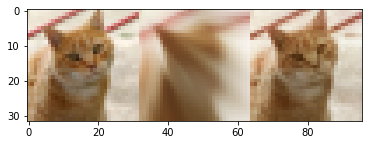

In [34]:
frames = Generate_GIF(img, n_PE=n_PE, epochs=epochs, lr=lr)
imageio.mimsave(os.path.join('GIFs', gif_name), frames, fps=20)
plt.imshow(frames[-1])